# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO implement 2.a Louvain Clustering and 2.d</span>

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations

In [1]:
from euclid_knn import knnG
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 26s, sys: 1.92 s, total: 2min 28s
Wall time: 2min 22s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

CPU times: user 2.25 s, sys: 56 ms, total: 2.31 s
Wall time: 1.75 s


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

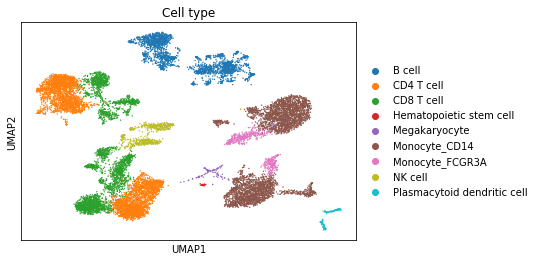

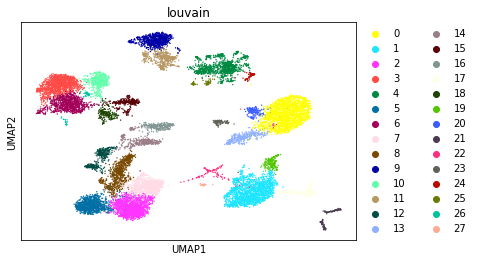

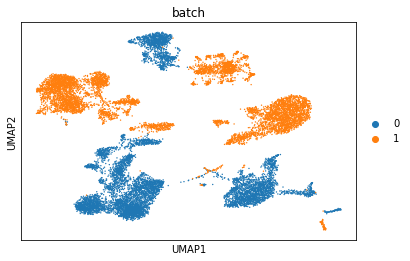

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [6]:
#anndata.obs['louvain'].head(3)

In [7]:
#anndata.obs.loc[:,['louvain', 'Cell type']].head()

In [8]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()
grouped = df.groupby(['louvain', 'Cell type'])
# grouped.describe()
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                     3
         Monocyte_CD14                  1907
         Monocyte_FCGR3A                  15
1        Monocyte_CD14                  1693
         Monocyte_FCGR3A                  25
2        CD4 T cell                     1433
         CD8 T cell                       17
3        CD4 T cell                     1245
         CD8 T cell                       18
4        B cell                         1038
         Monocyte_CD14                     1
5        CD4 T cell                        4
         CD8 T cell                      936
6        CD4 T cell                      921
         CD8 T cell                        3
7        CD4 T cell                      819
         CD8 T cell                       16
8        CD4 T cell                        2
         CD8 T cell                      747
         Monocyte_CD14                     1
9        B cell   

## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster